## Setup

## Torch setup
Install torch libraries that are needed to run
```python
import torch

import os
os.environ["TORCH"] = torch.__version__
```

```shell
!pip install torch_geometric
!pip install pytorch-lightning==2.4.0
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
```

## Other libraries
```shell
pip install matplotlib py3Dmol ipython
```

In [1]:
import os
from pathlib import Path
import shutil

import ase
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
from IPython.display import HTML

from mlfsm.cos import FreezingString
from mlfsm.geom import calculate_arc_length, project_trans_rot
from mlfsm.opt import CartesianOptimizer
from mlfsm.utils import load_xyz

## Load reactant and product

In [2]:
# Mannualy
reactant = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [-0.7630691361, -0.0020190208, 0.0034566355],
        [0.7626325757, 0.0019950530, 0.0009730411],
        [-1.1589043116, -0.5118960388, 0.8883793728],
        [1.1613211937, 0.5116793524, 0.8847263259],
        [-1.1629572511, 1.0174805269, 0.0041985317],
        [-1.1617577754, -0.5117033851, -0.8802966057],
        [1.1625206820, -1.0175044968, 0.0002310876],
        [1.1584677813, 0.5118721300, -0.8839496535],
    ],
)
product = ase.Atoms(
    symbols=["C", "C", "H", "H", "H", "H", "H", "H"],
    positions=[
        [0.8250132507, -0.3044255156, -0.0001793369],
        [-0.0708590455, 0.6761106267, -0.0016038483],
        [-2.2168320223, -1.1357962646, 0.0051867426],
        [-2.9069107362, -1.4149124935, 0.0006665373],
        [1.2144012074, -0.7244594455, -0.9242788205],
        [1.2098231719, -0.7260043834, 0.9251338654],
        [-0.4588134959, 1.0959757755, 0.9230324730],
        [-0.4554227885, 1.0988459975, -0.9270321510],
    ],
)
# Align product to reactant structure
_, aligned_product = project_trans_rot(reactant.get_positions(), product.get_positions())
product.set_positions(aligned_product.reshape(-1, 3))

In [3]:
# From benchmark set with helper function
reactant, product = load_xyz("data/06_diels_alder/")

# Run FSM

In [4]:
from schnet_ase_calculator import SchNetCalculator

# Parameters
nnodes_min = 18
interp = "ric"
ninterp = 50
method = "L-BFGS-B"
maxiter = 1
maxls = 3
dmax = 0.3

outdir = Path(f"FSM_run_Nodes_{nnodes_min}_interp_{interp}_maxiter_{maxiter}_maxls_{maxls}")
if outdir.exists():
    shutil.rmtree(outdir)
outdir.mkdir()

# Load calculator
ckpt = "pre_trained_gnns/schnet_fine_tuned.ckpt"
calc = SchNetCalculator(checkpoint=ckpt)

# Initialize string and optimizer
string = FreezingString(reactant, product, nnodes_min, interp, ninterp)
optimizer = CartesianOptimizer(calc, method, maxiter, maxls, dmax)

# Run
while string.growing:
    string.grow()
    string.optimize(optimizer)
    string.write(outdir)

print("Gradient calls:", string.ngrad)

Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pre_trained_gnns/schnet_fine_tuned.ckpt`
/home/jevandezande/progs/ML-FSM/.pixi/envs/dev/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['model.atomic_mass']


NNODES_MIN: 18
DIST: 5.719 STEPSIZE: 0.318
ITERATION: 1 DIST: 4.81 ENERGY: [2.4 2.2 0.4 0.0]
ITERATION: 2 DIST: 4.19 ENERGY: [2.4 2.2 2.2 1.7 0.4 0.0]
ITERATION: 3 DIST: 3.52 ENERGY: [2.4 2.2 2.2 2.2 2.0 1.7 0.4 0.0]
ITERATION: 4 DIST: 2.95 ENERGY: [2.4 2.2 2.2 2.2 2.3 3.4 2.0 1.7 0.4 0.0]
ITERATION: 5 DIST: 2.36 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 4.3 3.4 2.0 1.7 0.4 0.0]
ITERATION: 6 DIST: 1.74 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.4 4.3 4.3 3.4 2.0 1.7 0.4 0.0]
ITERATION: 7 DIST: 1.10 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.4 2.5 3.5 4.3 4.3 3.4 2.0 1.7 0.4 0.0]
ITERATION: 8 DIST: 0.49 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.4 2.5 2.5 2.8 3.5 4.3 4.3 3.4 2.0 1.7 0.4 0.0]
ITERATION: 9 DIST: 0.17 ENERGY: [2.4 2.2 2.2 2.2 2.3 2.3 2.4 2.5 2.5 2.6 2.8 3.5 4.3 4.3 3.4 2.0 1.7 0.4
 0.0]
Gradient calls: 51


## Plotting and Visualization

In [5]:
all_atoms = string.r_string + string.p_string[::-1]
all_energies = np.array(string.r_energy + string.p_energy[::-1])
all_energies = all_energies - min(all_energies)
ts_idx = all_energies.argmax()
path = [structure.get_positions() for structure in all_atoms]
s = calculate_arc_length(np.array(path))

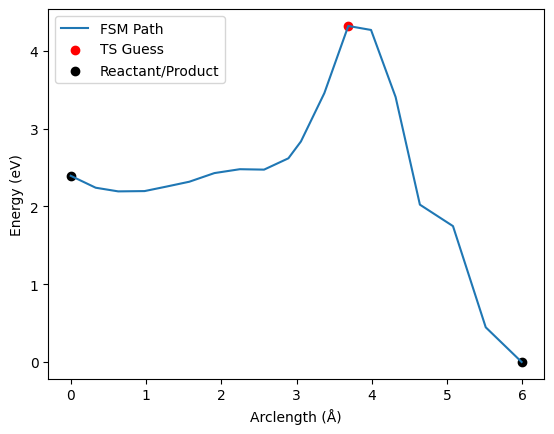

In [6]:
fig, ax = plt.subplots()
ax.plot(s, all_energies, label="FSM Path")
ax.scatter(s[ts_idx], all_energies[ts_idx], color="red", label="TS Guess")
ax.scatter(s[0], all_energies[0], color="black", label="Reactant/Product")
ax.scatter(s[-1], all_energies[-1], color="black")
ax.set_xlabel("Arclength (Å)")
ax.set_ylabel("Energy (eV)")
_ = ax.legend()

In [7]:
def snapshot_row(atoms_list: list[ase.Atoms], labels: list[str] | None = None) -> HTML:
    """Show selected structures."""
    html = []
    for i, atoms in enumerate(atoms_list):
        symbols = atoms.get_chemical_symbols()
        positions = atoms.get_positions()

        xyz_str = f"{len(atoms)}\n\n" + "\n".join(
            f"{sym} {x} {y} {z}"
            for sym, (x, y, z) in zip(symbols, positions, strict=True)
        )

        view = py3Dmol.view(width=250, height=250)
        view.addModel(xyz_str, "xyz")
        view.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius": 0.6}})
        view.zoomTo()

        # Generate label and viewer together
        label_text = labels[i] if labels else f"Frame {i}"
        viewer_html = view._make_html()

        # Combine label and viewer in a single column
        html.append(
            f"""
<div style='display:flex;flex-direction:column;align-items:center;margin-right:10px'>
    <div style='font-weight:bold;margin-bottom:4px;text-align:center'>{label_text}</div>
    {viewer_html}
</div>"""
        )

    return HTML(f"<div style='display:flex;gap:10px'>{''.join(html)}</div>")


# Example usage
frames_to_show = [all_atoms[0], all_atoms[ts_idx], all_atoms[-1]]
custom_labels = [
    "Reactant<br> Relative Energy: {:.1f} eV".format(all_energies[0]),
    "TS Guess<br> Relative Energy: {:.1f} eV".format(all_energies[ts_idx]),
    "Product<br> Relative Energy: {:.1f} eV".format(all_energies[-1]),
]
snapshot_row(frames_to_show, custom_labels)